#### Transiting to Backpropagation
- Let's go back to our simple FNN to put things in perspective
    - Let us ignore non-linearities for now to keep it simpler, but it's just a tiny change subsequently
    - Given a linear transformation on our input (for simplicity instead of an affine transformation that includes a bias): $\hat y = \theta x$
        - $\theta$ is our parameters
        - $x$ is our input
        - $\hat y$ is our prediction
    - Then we have our MSE loss function $L = \frac{1}{2} (\hat y - y)^2$
- We need to calculate our partial derivatives of our loss w.r.t. our parameters to update our parameters: $\nabla_{\theta} = \frac{\delta L}{\delta \theta}$
    - With chain rule we have $\frac{\delta L}{\delta \theta} = \frac{\delta L}{\delta \hat y} \frac{\delta \hat y}{\delta \theta}$
        - $\frac{\delta L}{\delta \hat y} = (\hat y -  y)$
        - $\frac{\delta \hat y}{\delta \theta}$ is our partial derivatives of $y$ w.r.t. our parameters (our gradient) as we have covered previously
        

#### Forward Propagation, Backward Propagation and Gradient Descent
- All right, now let's put together what we have learnt on backpropagation and apply it on a simple feedforward neural network (FNN)
- Let us assume the following simple FNN architecture and take note that we do not have bias here to keep things simple
    - FNN architecture
        1. Linear function: hidden size = 32
        2. Non-linear function: sigmoid
        3. Linear function: output size = 1
        4. Non-linear function: sigmoid
    - We will be going through a binary classification problem classifying 2 types of flowers
        - Output size: 1 (represented by 0 or 1 depending on the flower)
        - Input size: 2 (features of the flower)

![](./images/manual_bp.png) 

In [1]:
import torch
import torch.nn as nn

In [2]:
from sklearn import datasets
from sklearn import preprocessing
iris = datasets.load_iris()
X = torch.tensor(preprocessing.normalize(iris.data[:, :2]), dtype=torch.float)
y = torch.tensor(iris.target.reshape(-1, 1), dtype=torch.float)

In [3]:
# Set manual seed
torch.manual_seed(2)

In [4]:
print(X.size())
print(y.size())

torch.Size([150, 2])
torch.Size([150, 1])


In [5]:
# We only take 2 classes to make a binary classification problem
X = X[:y[y < 2].size()[0]]
y = y[:y[y < 2].size()[0]]

In [6]:
print(X.size())
print(y.size())

torch.Size([100, 2])
torch.Size([100, 1])


In [7]:
print(torch.randn(2, 32).size())

torch.Size([2, 32])


In [8]:
class FNN(nn.Module):
    def __init__(self, ):
        super().__init__()
        
        # Dimensions for input, hidden and output
        self.input_dim = 2
        self.hidden_dim = 32
        self.output_dim = 1
        
        # Learning rate definition
        self.learning_rate = 0.001
        
        # Our parameters (weights)
        # w1: 2 x 32
        self.w1 = torch.randn(self.input_dim, self.hidden_dim)
        
        # w2: 32 x 1
        self.w2 = torch.randn(self.hidden_dim, self.output_dim)
    
    def sigmoid(self, s):
        return 1 / (1 + torch.exp(-s))
    
    def sigmoid_first_order_derivative(self, s):
        return s * (1 - s)
    
    # Forward propagation
    def forward(self, X):
        # First linear layer
        self.y1 = torch.matmul(X, self.w1) # 3 X 3 ".dot" does not broadcast in PyTorch
        
        # First non-linearity
        self.y2 = self.sigmoid(self.y1)
        
        # Second linear layer
        self.y3 = torch.matmul(self.y2, self.w2)
        
        # Second non-linearity
        y4 = self.sigmoid(self.y3)
        return y4
        
    # Backward propagation
    def backward(self, X, l, y4):
        # Derivative of binary cross entropy cost w.r.t. final output y4
        self.dC_dy4 = y4 - l
        
        '''
        Gradients for w2: partial derivative of cost w.r.t. w2
        dC/dw2
        '''
        self.dy4_dy3 = self.sigmoid_first_order_derivative(y4)
        self.dy3_dw2 = self.y2
        
        # Y4 delta: dC_dy4 dy4_dy3
        self.y4_delta = self.dC_dy4 * self.dy4_dy3
        
        # This is our gradients for w1: dC_dy4 dy4_dy3 dy3_dw2
        self.dC_dw2 = torch.matmul(torch.t(self.dy3_dw2), self.y4_delta)
        
        '''
        Gradients for w1: partial derivative of cost w.r.t w1
        dC/dw1
        '''
        self.dy3_dy2 = self.w2
        self.dy2_dy1 = self.sigmoid_first_order_derivative(self.y2)
        
        # Y2 delta: (dC_dy4 dy4_dy3) dy3_dy2 dy2_dy1
        self.y2_delta = torch.matmul(self.y4_delta, torch.t(self.dy3_dy2)) * self.dy2_dy1
        
        # Gradients for w1: (dC_dy4 dy4_dy3) dy3_dy2 dy2_dy1 dy1_dw1
        self.dC_dw1 = torch.matmul(torch.t(X), self.y2_delta)
        
        # Gradient descent on the weights from our 2 linear layers
        self.w1 -= self.learning_rate * self.dC_dw1
        self.w2 -= self.learning_rate * self.dC_dw2

    def train(self, X, l):
        # Forward propagation
        y4 = self.forward(X)
        
        # Backward propagation and gradient descent
        self.backward(X, l, y4)

In [9]:
# Instantiate our model class and assign it to our model object
model = FNN()

# Loss list for plotting of loss behaviour
loss_lst = []

# Number of times we want our FNN to look at all 100 samples we have, 100 implies looking through 100x
num_epochs = 101

# Let's train our model with 100 epochs
for epoch in range(num_epochs):
    # Get our predictions
    y_hat = model(X)
    
    # Cross entropy loss, remember this can never be negative by nature of the equation
    # But it does not mean the loss can't be negative for other loss functions
    cross_entropy_loss = -(y * torch.log(y_hat) + (1 - y) * torch.log(1 - y_hat))
    
    # We have to take cross entropy loss over all our samples, 100 in this 2-class iris dataset
    mean_cross_entropy_loss = torch.mean(cross_entropy_loss).detach().item()
    
    # Print our mean cross entropy loss
    if epoch % 20 == 0:
        print('Epoch {} | Loss: {}'.format(epoch, mean_cross_entropy_loss))
    loss_lst.append(mean_cross_entropy_loss)
    
    # (1) Forward propagation: to get our predictions to pass to our cross entropy loss function
    # (2) Back propagation: get our partial derivatives w.r.t. parameters (gradients)
    # (3) Gradient Descent: update our weights with our gradients
    model.train(X, y)

Epoch 0 | Loss: 0.9228229522705078
Epoch 20 | Loss: 0.6966760754585266
Epoch 40 | Loss: 0.6714916229248047
Epoch 60 | Loss: 0.6686137914657593
Epoch 80 | Loss: 0.666690468788147
Epoch 100 | Loss: 0.6648102402687073


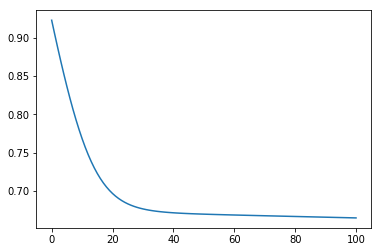

In [10]:
import pandas as pd
%matplotlib inline
pd.Series(loss_lst).plot()